# Time Line
### 3.16
* ricardo: train model on whole dataset, add distance
* yiqi: add distance, use randomforest, format current notebook

## Target- urgent withdrawn by nurse(within 24hr)
* shift_applications status == 'cancelled' + shift_application prevStatus == 'confirmed'


### IDs -> only look at shifts application, leave each shifts after
* shift_applications id
* shift_applications user_id
* shift_applications shift_id


### Numeric Field
* shifts rate
* shifts net_pay: rate - nursedash profit
* shift_applications distance
* shift break time
* user withdrawn times: 
    Problem: 
        1. We don't know in reality that you will withdraw your previous one.
        2. cannot be used to predict new user
* user applied times:
* <b>prev SA/CW rate<b/>


## Time
### shift, shift app time
* S_Create (shift created) => SA_Create (application created) => CWTime (comfim withdrawn) => Start_Time (shift start)
* S_Create: shift create time
* SA_Create: shift application create time
* CWTime: shift withdrawn time, whole confirmed withdrawn population (include within 24hr and > 24hr)
* Start_Time: shift start time
##### calculated field, graph in hours
* <b>S_Create2SA_Create<b/>: shift application create time - shift create time
* <b>S_Create2Start_Time<b/>: shift start time - shift create time
        1. has negative values. delete maybe?
* <b>SA_Create2Start_Time<b/>: shift start time - shift application create time
        1. has negative values. delete maybe?

### User
* user approvedAt:
* user createdAt:
#### Calculated field
* U_Create2U_approved: User approve time - User create time
* <b>U_Create2now<b/>: now - User create time, in months(seconds/2629746)
* <b>U_Approve2now<b/>: now - User approve time


### Categorical
* shifts role: position name + type
* facilities name = facilities short_name
* facilities areaId = facilities areaName
* withdrawnInfo_key, withdrawnInfo_value
* facilities segmentName: Senior Living = 1, Healthcare = 0
* Users enableNotifications:
* Users emailNotifications:
* Users appNotifications:
* Users allowedNotifications:


### ?
* facilities allowedQualification
* facilities createdAt
* facilities rates
* nurse shift withdrawn by admin, when policy start, how many withdrawn by admin
* shifts = unit
* role
* users updateAt ?
* users relationToFacility

# Data Cleaning

In [281]:
import pandas as pd
import numpy as np
df = pd.read_csv('main.csv').drop(columns = ['Unnamed: 0'])
df.columns

Index(['id', 'user_id', 'shift_id', 'status', 'createdAt',
       'hasNurseCheckEvent', 'hasBreakTime', 'prevStatus', 'distance', 'id.1',
       'facility_id', 'description', 'start_time', 'assigned_nurse_id', 'rate',
       'net_pay', 'unit', 'type', 'createdAt.1', 'qualifications', 'breakTime',
       'prevStatus.1', 'id.2', 'name', 'short_name', 'createdAt.2', 'rates',
       'S_Create', 'SA_Create', 'S_create2SA_Create', 'Start_Time',
       'SA_Create2Start_Time', 'S_Create2Start_Time', 'CW_Time',
       'CW_Time2Start_Time', 'SA_Create2CW_Time', 'S_Create2CW_Time',
       'allowedQualifications', 'areaId', 'areaName', 'segmentName',
       'U_create2now', 'U_approve2now', 'U_create2U_approve',
       'withdrawnInfo_key', 'withdrawnInfo_value', 'tar'],
      dtype='object')

In [282]:
df.shape

(169654, 47)

In [283]:
#df['tar'] = df.apply(lambda x: 1 if x['status'] == 'withdrawn' and x['prevStatus'] == 'confirmed' and x['withdrawnInfo_value'] == 'nurse' and df['CW_Time2Start_Time'] > -24 else 0, axis =1)

In [284]:
def CW_by_nurse(row):
    if row['status']=='withdrawn' and row['prevStatus'] == 'confirmed':
        if row['withdrawnInfo_value'] == 'nurse':
            if row['CW_Time2Start_Time'] < 0 and row['CW_Time2Start_Time'] >= -24:
                return 1
            else:
                return 0
        else:
            return 0
    else:
        return 0
    
df['target'] = df.apply (lambda row: CW_by_nurse(row), axis=1)

In [285]:
df['target'].value_counts()

0    165284
1      4370
Name: target, dtype: int64

In [286]:
# There are some negative numbers in this column. Not very much. 
# I think we need to delete these data entries since it make it impossible to nurse to apply on time.

df = df[(df["S_Create2Start_Time"]>0) & (df["SA_Create2Start_Time"]>0)]

In [287]:
# df2 is a sorted version of df1, data is exactly the same
df1 = df.set_index(['user_id','id'])
df2 = df1.sort_index()
df2 = df2.reset_index()

In [288]:
def count_prev_SA(df):
    count_prev_SA = []
    id_number = 0
    count = 0
    user_id = list(df2['user_id'])
    for i in user_id:
        if id_number == i:
            count += 1
            count_prev_SA.append(count)
            id_number = i
        else:
            count = 0
            count_prev_SA.append(count)
            id_number = i
    return count_prev_SA

        
df2['count_prev_SA'] = count_prev_SA(df2)

In [289]:
def count_prev_CW(df):
    count_prev_CW = []
    id_number = 0
    count = 0
    user_id = list(df2['user_id'])
    urgent_CW = list(df2['target'])
    for i,v in enumerate(user_id):
        if id_number == v:
            count_prev_CW.append(count)
            if urgent_CW[i] == 1:
                count += 1
            id_number = v
        else:
            count = 0
            count_prev_CW.append(count)
            if urgent_CW[i] == 1:
                count += 1
            id_number = v
    return count_prev_CW

        
df2['count_prev_CW'] = count_prev_CW(df2)

In [290]:
df2['prev_CW/SA_rate'] = df2['count_prev_CW']/df2['count_prev_SA']
df2['prev_CW/SA_rate'].fillna(0,inplace=True)

In [291]:
df2.head(5)

,user_id,id,shift_id,status,createdAt,hasNurseCheckEvent,hasBreakTime,prevStatus,distance,id.1,...,U_create2now,U_approve2now,U_create2U_approve,withdrawnInfo_key,withdrawnInfo_value,tar,target,count_prev_SA,count_prev_CW,prev_CW/SA_rate
0,18,29072,12460,applied,2019-09-11 17:58:36.854268,f,f,withdrawn,NaN,12460,...,31.27281,24.076044,219.04706,NaN,NaN,0,0,0,0,0.0
1,18,29706,12685,applied,2019-09-16 16:19:11.890038,f,f,NaN,NaN,12685,...,31.27281,24.076044,219.04706,NaN,NaN,0,0,1,0,0.0
2,18,36042,15920,confirmed,2019-10-29 01:59:31.169775,t,f,selected,NaN,15920,...,31.27281,24.076044,219.04706,NaN,NaN,0,0,2,0,0.0
3,18,40273,17541,confirmed,2019-11-18 20:14:34.591996,t,t,selected,NaN,17541,...,31.27281,24.076044,219.04706,NaN,NaN,0,0,3,0,0.0
4,18,40656,17809,interested,2019-11-20 03:53:30.618811,f,f,applied,NaN,17809,...,31.27281,24.076044,219.04706,NaN,NaN,0,0,4,0,0.0


In [292]:
df2['prev_CW/SA_rate']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
167718    0.666667
167719    0.500000
167720    0.000000
167721    0.000000
167722    0.000000
Name: prev_CW/SA_rate, Length: 167723, dtype: float64

In [293]:
# create type dummy: RN = 1, LVN + LPN = 2, rest = 0
def create_type_dummy(row):
    if row['type']=='RN':
        return 2
    elif row['type'] == 'LVN' or row['type'] == 'LPN':
        return 1
    else:
        return 0
    
df2['type_d'] = df2.apply(lambda row: create_type_dummy(row), axis=1)

In [294]:
# create type dummy: Senior Living, Healthcare
def create_segmentName_dummy(row):
    if row['segmentName']=='Senior Living':
        return 1
    else:
        return 0
    
df2['segmentName_d'] = df2.apply(lambda row: create_segmentName_dummy(row), axis=1)

In [295]:
df2 = df2[['prev_CW/SA_rate','S_create2SA_Create','S_Create2Start_Time','SA_Create2Start_Time','U_create2now',
          'U_approve2now', 'type_d','segmentName_d','net_pay','target']]
df2.to_csv('model_data.csv')

# Logistic Regression 1  

# import 'model_data.csv' as df2

In [261]:
from sklearn import preprocessing
 
# standardization of dependent variables
df2['prev_CW/SA_rate'] = preprocessing.scale(df2['prev_CW/SA_rate'])
df2['S_create2SA_Create'] = preprocessing.scale(df2['S_create2SA_Create'])
df2['S_Create2Start_Time'] = preprocessing.scale(df2['S_Create2Start_Time'])
df2['SA_Create2Start_Time'] = preprocessing.scale(df2['SA_Create2Start_Time'])
df2['U_create2now'] = preprocessing.scale(df2['U_create2now'])
df2['U_approve2now'] = preprocessing.scale(df2['U_approve2now'])

In [262]:
df2['net_pay'] = preprocessing.scale(df2['net_pay'])

In [263]:
df3 = df2[['prev_CW/SA_rate','S_create2SA_Create','S_Create2Start_Time','SA_Create2Start_Time','U_create2now',
          'U_approve2now', 'type_d','segmentName_d','net_pay','target']]

In [192]:
# make nontar dataset length = target dataset
import random
df3_tar = df3[df3['target']==1]
df3_nontar = df3[df3['target']==0]

number_of_tar = df3_tar.shape[0]
random_indices = random.sample(range(len(df3_nontar)), int(number_of_tar))
df3_nontar = df3_nontar[df3_nontar.index.isin(random_indices)]

In [193]:
df3_nontar.head(5)

,prev_CW/SA_rate,S_create2SA_Create,S_Create2Start_Time,SA_Create2Start_Time,U_create2now,U_approve2now,type_d,segmentName_d,net_pay,target
15,-0.509372,-0.601328,-1.126353,-0.995839,2.476451,1.843646,2,0,2.232591,0
85,-0.509372,1.127278,0.927211,0.197023,2.476451,1.833457,2,1,2.232591,0
134,-0.509372,-0.416745,-0.448786,-0.223278,2.476437,1.833442,2,1,3.322607,0
148,-0.296877,-0.440588,-0.832250,-0.739709,2.476437,1.833442,2,0,4.739627,0
154,-0.109139,-0.387943,-0.053007,0.305613,2.476437,1.833442,2,0,2.450594,0


In [194]:
df4 = pd.concat([df3_tar, df3_nontar])

def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)

df4 = shuffle(df4)

In [195]:
df4.isna().sum()

prev_CW/SA_rate         0
S_create2SA_Create      0
S_Create2Start_Time     0
SA_Create2Start_Time    0
U_create2now            0
U_approve2now           2
type_d                  0
segmentName_d           0
net_pay                 0
target                  0
dtype: int64

In [196]:
df4.dropna(inplace=True)

In [197]:
def summary_coef(model_object):
    n_predictors = X.shape[1]
    model_coef = pd.DataFrame(model_object.coef_.reshape(1,n_predictors),columns = X.columns.values)
    model_coef['Intercept'] = model_object.intercept_
    return (model_coef.transpose())

In [198]:
from sklearn.model_selection import train_test_split

#Splitting the data into our partitions will return two dataframes, so we must prep like so:
testpart_size = .2
df_partition = df

df_nontestdata, df_testdata = train_test_split(df4, test_size = testpart_size, random_state = 1)

In [199]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X = df_nontestdata.drop(columns = ['target'])
y = df_nontestdata['target']


kfolds=5

min_alpha = .01
max_alpha = 100

max_C = 1/min_alpha
min_C = 1/max_alpha

n_candidates = 5000
c_list= list(np.linspace(min_C, max_C, num = n_candidates))

#Plug in clf_optimal to our previous Logistic model to find the optimal predictors
clf_optimal = LogisticRegressionCV(Cs = c_list,cv=kfolds, penalty = 'l1', scoring='roc_auc',solver='saga',max_iter=200, random_state=1, n_jobs = -1).fit(X,y)

#Find the optimal selected alpha
print(1/clf_optimal.C_)

[1.05252741]


In [200]:
logit = LogisticRegressionCV(scoring='roc_auc')
logit.fit(X,y)

LogisticRegressionCV(scoring='roc_auc')

In [201]:
X_test = df_testdata.drop(columns = ['target'])
y_test = df_testdata['target']

In [202]:
df_testdata

,prev_CW/SA_rate,S_create2SA_Create,S_Create2Start_Time,SA_Create2Start_Time,U_create2now,U_approve2now,type_d,segmentName_d,net_pay,target
4670,0.575471,-0.248676,-0.343532,-0.240212,-0.324889,-0.198137,0,1,0.052559,1
5836,-0.509372,-0.601098,1.050882,2.069105,0.751083,0.988567,0,1,-0.928455,0
6421,3.238266,-0.597116,-0.599816,-0.258704,-1.454636,-1.469723,0,1,0.161561,1
4515,0.472152,-0.580091,-0.791072,-0.544686,-1.387096,-1.369684,0,1,-0.165444,1
4701,0.778878,-0.585033,-0.669172,-0.368215,1.206712,-1.247053,1,1,0.761070,0
...,...,...,...,...,...,...,...,...,...,...
6266,0.420493,-0.439346,-0.520563,-0.302125,0.043467,0.222426,0,1,-0.328946,1
7718,0.604791,0.464729,0.042590,-0.397477,1.177032,0.993472,0,1,-0.465198,0
5193,-0.171470,-0.371987,-0.308514,-0.069769,-0.823279,-1.095880,0,0,-0.628700,0
975,0.912146,-0.576973,-0.684341,-0.397491,-1.430181,-1.464477,0,1,-0.383447,0


In [203]:
y_prob = logit.predict_proba(X_test)
y_pred= logit.predict(X_test)

In [204]:
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,roc_curve)
from sklearn.metrics import confusion_matrix
# accuracy_score(y_test,y_pred)

In [205]:
print(roc_auc_score(y_test, y_pred))

0.634582037508246


In [206]:
# from sklearn.metrics import classification_report,confusion_matrix

# print(confusion_matrix(y_test, y_pred))
# print('\n')
# print(classification_report(y_test, y_pred))

# !!! call cf_matrix.py in the confusion_matrix folder to run

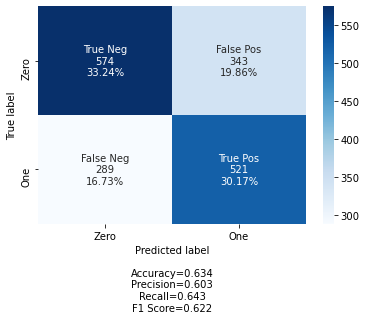

In [207]:
from cf_matrix import make_confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [208]:
# summary_coef(logit)

In [209]:
import matplotlib.pyplot as plt
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

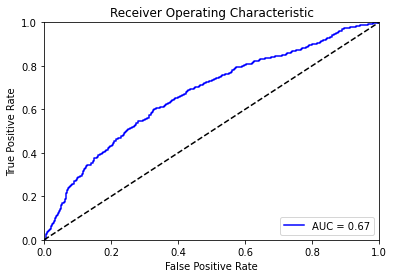

In [118]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [119]:
import statsmodels.api as sm
smlogit = sm.Logit(y,X).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.657521
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 6894
Model:                          Logit   Df Residuals:                     6885
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:                 0.05130
Time:                        13:01:29   Log-Likelihood:                -4532.9
converged:                       True   LL-Null:                       -4778.0
Covariance Type:            nonrobust   LLR p-value:                8.921e-101
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
prev_CW/SA_rate          0.1907      0.028      6.810      0.000       0.136       0.246
S_create2SA_Create       0.7361      1.096      0.672      0.502      -1.411       2.884
S_Create2Start_Time     -1.0227      1.575     -0.649      0.516      -4.110       2.064
SA_Create2Start_Time     0.5452      1.117      0.488      0.625      -1.643       2.734
U_create2now             0.0673      0.070      0.960      0.337      -0.070       0.205
U_approve2now           -0.0646      0.070     -0.927      0.354      -0.201       0.072
type_d                  -1.6878      0.104    -16.303      0.000      -1.891      -1.485
segmentName_d            0.4389      0.036     12.177      0.000       0.368       0.510
net_pay                  1.0215      0.064     15.856      0.000       0.895       1.148
========================================================================================
"""

# Logistic Regression2, pick only significant vars

In [159]:
# sample non target = target

In [216]:
X = df4[['prev_CW/SA_rate', 'type_d', 'segmentName_d', 'net_pay', 'U_approve2now']]
Y = df4['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

In [217]:
logit = LogisticRegressionCV(scoring='roc_auc')
logit.fit(X_train,y_train)
y_pred= logit.predict(X_test)

In [218]:
smlogit = sm.Logit(y_train,X_train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.654028
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 6042
Model:                          Logit   Df Residuals:                     6037
Method:                           MLE   Df Model:                            4
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:                 0.05602
Time:                        14:00:03   Log-Likelihood:                -3951.6
converged:                       True   LL-Null:                       -4186.1
Covariance Type:            nonrobust   LLR p-value:                3.406e-100
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
prev_CW/SA_rate     0.2772      0.032      8.623      0.000       0.214       0.340
type_d             -1.6630      0.108    -15.420      0.000      -1.874      -1.452
segmentName_d       0.4674      0.038     12.256      0.000       0.393       0.542
net_pay             1.0059      0.068     14.692      0.000       0.872       1.140
U_approve2now      -0.0683      0.029     -2.382      0.017      -0.124      -0.012
===================================================================================
"""

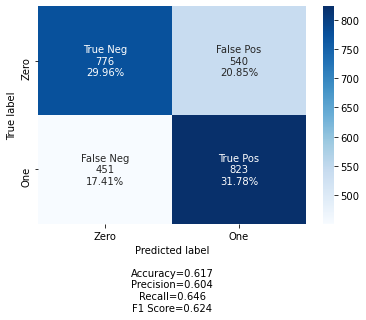

In [219]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(confusion_matrix(y_test, y_pred), 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [215]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[772 521]
 [444 853]]


              precision    recall  f1-score   support

           0       0.63      0.60      0.62      1293
           1       0.62      0.66      0.64      1297

    accuracy                           0.63      2590
   macro avg       0.63      0.63      0.63      2590
weighted avg       0.63      0.63      0.63      2590

